In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from google.colab import drive

In [2]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/Car Plate Dataset.zip'
extract_path = '/content/car_dataset'
dataset_path = '/content/car_dataset/Car Plate Dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
print(os.listdir('/content/car_dataset/Car Plate Dataset'))
print(os.listdir('/content/car_dataset/Car Plate Dataset/images'))

['MetaData.csv', 'images']
['235.jpeg', '1261.jpeg', '559.jpeg', '192.jpeg', '4294.jpeg', '284.jpeg', '1630.jpeg', '1818.jpeg', '3463.jpeg', '1864.jpeg', '1036.jpeg', '211.jpeg', '1681.jpeg', '231.jpeg', '3537.jpeg', '1081.jpeg', '151.jpeg', '3293.jpeg', '80.jpeg', '225.jpeg', '4204.jpeg', '374.jpeg', '4213.jpeg', '4553.jpeg', '194.jpeg', '103.jpeg', '769.jpeg', '230.jpeg', '4861.jpeg', '2983.jpeg', '161.jpeg', '2985.jpeg', '2102.jpeg', '295.jpeg', '4471.jpeg', '394.jpeg', '4223.jpeg', '565.jpeg', '3363.jpeg', '145.jpeg', '154.jpeg', '719.jpeg', '2195.jpeg', '1322.jpeg', '61.jpeg', '3757.jpeg', '234.jpeg', '1106.jpeg', '1810.jpeg', '56.jpeg', '116.jpeg', '4216.jpeg', '1673.jpeg', '335.jpeg', '4133.jpeg', '1170.jpeg', '457.jpeg', '593.jpeg', '1928.jpeg', '4636.jpeg', '921.jpeg', '4526.jpeg', '87.jpeg', '4112.jpeg', '4226.jpeg', '2.jpeg', '17.jpeg', '136.jpeg', '2795.jpeg', '3570.jpeg', '65.jpeg', '502.jpeg', '150.jpeg', '2991.jpeg', '3168.jpeg', '882.jpeg', '40.jpeg', '756.jpeg', '458.j

In [5]:
metadata = pd.read_csv(os.path.join(extract_path, 'Car Plate Dataset', 'MetaData.csv'))
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(extract_path, 'Car Plate Dataset', 'images', f'{x}.jpeg'))

In [6]:
metadata = metadata[metadata['image_id'] != '111']

file_to_remove = os.path.join(extract_path, 'Car Plate Dataset', 'images', '111.jpeg')
if os.path.exists(file_to_remove):
    os.remove(file_to_remove)
    print(f"File {file_to_remove} has been removed.")

File /content/car_dataset/Car Plate Dataset/images/111.jpeg has been removed.


In [7]:
print("Contents of extracted folder:")
print(os.listdir(extract_path))
print("\nContents of dataset folder:")
print(os.listdir(dataset_path))
print("\nContents of images folder:")
print(os.listdir(os.path.join(dataset_path, 'images')))

Contents of extracted folder:
['Car Plate Dataset']

Contents of dataset folder:
['MetaData.csv', 'images']

Contents of images folder:
['235.jpeg', '1261.jpeg', '559.jpeg', '192.jpeg', '4294.jpeg', '284.jpeg', '1630.jpeg', '1818.jpeg', '3463.jpeg', '1864.jpeg', '1036.jpeg', '211.jpeg', '1681.jpeg', '231.jpeg', '3537.jpeg', '1081.jpeg', '151.jpeg', '3293.jpeg', '80.jpeg', '225.jpeg', '4204.jpeg', '374.jpeg', '4213.jpeg', '4553.jpeg', '194.jpeg', '103.jpeg', '769.jpeg', '230.jpeg', '4861.jpeg', '2983.jpeg', '161.jpeg', '2985.jpeg', '2102.jpeg', '295.jpeg', '4471.jpeg', '394.jpeg', '4223.jpeg', '565.jpeg', '3363.jpeg', '145.jpeg', '154.jpeg', '719.jpeg', '2195.jpeg', '1322.jpeg', '61.jpeg', '3757.jpeg', '234.jpeg', '1106.jpeg', '1810.jpeg', '56.jpeg', '116.jpeg', '4216.jpeg', '1673.jpeg', '335.jpeg', '4133.jpeg', '1170.jpeg', '457.jpeg', '593.jpeg', '1928.jpeg', '4636.jpeg', '921.jpeg', '4526.jpeg', '87.jpeg', '4112.jpeg', '4226.jpeg', '2.jpeg', '17.jpeg', '136.jpeg', '2795.jpeg', '3570.

In [8]:
print("\nSample image paths:")
print(metadata['image_path'].head())


Sample image paths:
0    /content/car_dataset/Car Plate Dataset/images/...
1    /content/car_dataset/Car Plate Dataset/images/...
2    /content/car_dataset/Car Plate Dataset/images/...
3    /content/car_dataset/Car Plate Dataset/images/...
4    /content/car_dataset/Car Plate Dataset/images/...
Name: image_path, dtype: object


In [9]:
def check_image_files(metadata):
    missing_files = []
    for _, row in metadata.iterrows():
        if not os.path.exists(row['image_path']):
            missing_files.append(row['image_path'])

    if missing_files:
        print(f"Warning: {len(missing_files)} image files are missing.")
        print("First few missing files:")
        print(missing_files[:5])
    else:
        print("All image files exist.")

check_image_files(metadata)

First few missing files:
['/content/car_dataset/Car Plate Dataset/images/111.jpeg', '/content/car_dataset/Car Plate Dataset/images/121.jpeg']


In [10]:
print(f"befor filter : {len(metadata)}")
metadata = metadata[metadata['image_path'].apply(os.path.exists)]
print(f"after filter : {len(metadata)}")

befor filter : 925
after filter : 923


In [11]:
label_encoders = {}
categorical_columns = ['name', 'color', 'direction']  # Removed 'type'

for column in categorical_columns:
    le = LabelEncoder()
    metadata[f'{column}_encoded'] = le.fit_transform(metadata[column])
    label_encoders[column] = le

In [12]:
train_data, val_data = train_test_split(metadata, test_size=0.2, random_state=42)

In [13]:
img_size = (224, 224)
batch_size = 16

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest',
    brightness_range=[0.9, 1.1],
    channel_shift_range=20.0,
    preprocessing_function=lambda x: tf.image.random_jpeg_quality(x, 75, 95)
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
def preprocess_image(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    return img_array

def data_generator(data, batch_size, is_training=True):
    while True:
        for i in range(0, len(data), batch_size):
            batch_data = data.iloc[i:i+batch_size]
            batch_images = []
            batch_labels = {col: [] for col in categorical_columns}

            for _, row in batch_data.iterrows():
                img = preprocess_image(row['image_path'])
                batch_images.append(img)

                for col in categorical_columns:
                    batch_labels[col].append(label_encoders[col].transform([row[col]])[0])

            batch_images = np.array(batch_images)
            for col in categorical_columns:
                batch_labels[col] = np.array(batch_labels[col])

            yield batch_images, batch_labels

In [16]:
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(1,),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        at = tf.keras.backend.softmax(et, axis=1)
        output = x * at
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

In [17]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = AttentionLayer()(x)

outputs = {}
for column in categorical_columns:
    num_classes = len(label_encoders[column].classes_)
    outputs[column] = layers.Dense(num_classes, activation='softmax', name=column)(x)

model = models.Model(inputs=inputs, outputs=outputs)

loss_weights = {
    'name': 1.5,
    'color': 1.0,
    'direction': 1.0
}

initial_learning_rate = 0.001

optimizer = Adam(learning_rate=initial_learning_rate, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss={col: 'sparse_categorical_crossentropy' for col in categorical_columns},
              loss_weights=loss_weights,
              metrics={col: 'accuracy' for col in categorical_columns})

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    data_generator(train_data, batch_size),
    steps_per_epoch=len(train_data) // batch_size,
    epochs=100,
    validation_data=data_generator(val_data, batch_size, is_training=False),
    validation_steps=len(val_data) // batch_size,
    callbacks=[reduce_lr, model_checkpoint]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 126s 392ms/step - color_accuracy: 0.2650 - direction_accuracy: 0.7022 - loss: 9.9684 - name_accuracy: 0.0880 - val_color_accuracy: 0.1420 - val_direction_accuracy: 0.5000 - val_loss: 10.6611 - val_name_accuracy: 0.0966 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 71s 332ms/step - color_accuracy: 0.4607 - direction_accuracy: 0.9041 - loss: 7.6667 - name_accuracy: 0.2269 - val_color_accuracy: 0.2663 - val_direction_accuracy: 0.4852 - val_loss: 59.5776 - val_name_accuracy: 0.0651 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 215ms/step - color_accuracy: 0.6042 - direction_accuracy: 0.9410 - loss: 6.3046 - name_accuracy: 0.3132 - val_color_accuracy: 0.2012 - val_direction_accuracy: 0.5148 - val_loss: 51.5715 - val_name_accuracy: 0.0118 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - color_accuracy: 0.6532 - direction_accuracy: 0.933

dict_keys(['color_accuracy', 'direction_accuracy', 'loss', 'name_accuracy', 'val_color_accuracy', 'val_direction_accuracy', 'val_loss', 'val_name_accuracy', 'learning_rate'])


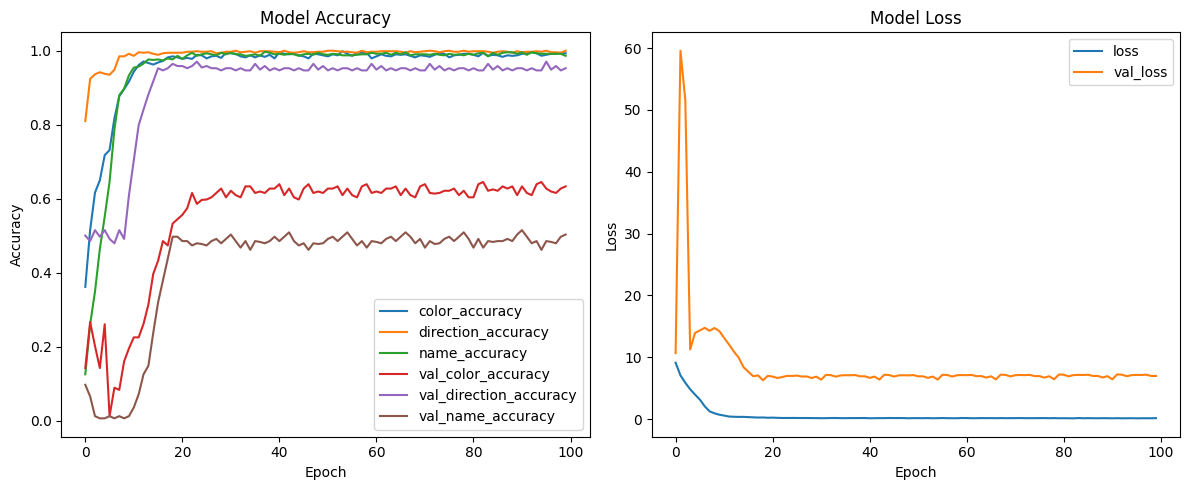

In [18]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    print(history.history.keys())

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    for key in history.history.keys():
        if 'acc' in key and 'val' not in key:
            plt.plot(history.history[key], label=key)
    for key in history.history.keys():
        if 'acc' in key and 'val' in key:
            plt.plot(history.history[key], label=key)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(122)
    for key in history.history.keys():
        if 'loss' in key and 'val' not in key:
            plt.plot(history.history[key], label=key)
    for key in history.history.keys():
        if 'loss' in key and 'val' in key:
            plt.plot(history.history[key], label=key)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [19]:
import os

save_dir = '/content/drive/MyDrive/PlateModel'
os.makedirs(save_dir, exist_ok=True)
model.save(os.path.join(save_dir, 'car_plate_model.keras'))

In [22]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/PlateModel/car_plate_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmphiu2_870'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  Dict[['name', TensorSpec(shape=(None, 122), dtype=tf.float32, name=None)], ['color', TensorSpec(shape=(None, 28), dtype=tf.float32, name=None)], ['direction', TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]]
Captures:
  134576516047168: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134573950006752: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134573940666816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134573940667696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134573940666992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134573940667872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134573940670160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134573941032912: TensorSpec(shape=(), dty

In [23]:
def predict_car_info(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)

    results = {}
    for column, pred in zip(categorical_columns, predictions.values()):
        predicted_class = label_encoders[column].inverse_transform([np.argmax(pred[0])])[0]
        results[column] = predicted_class

    return results

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


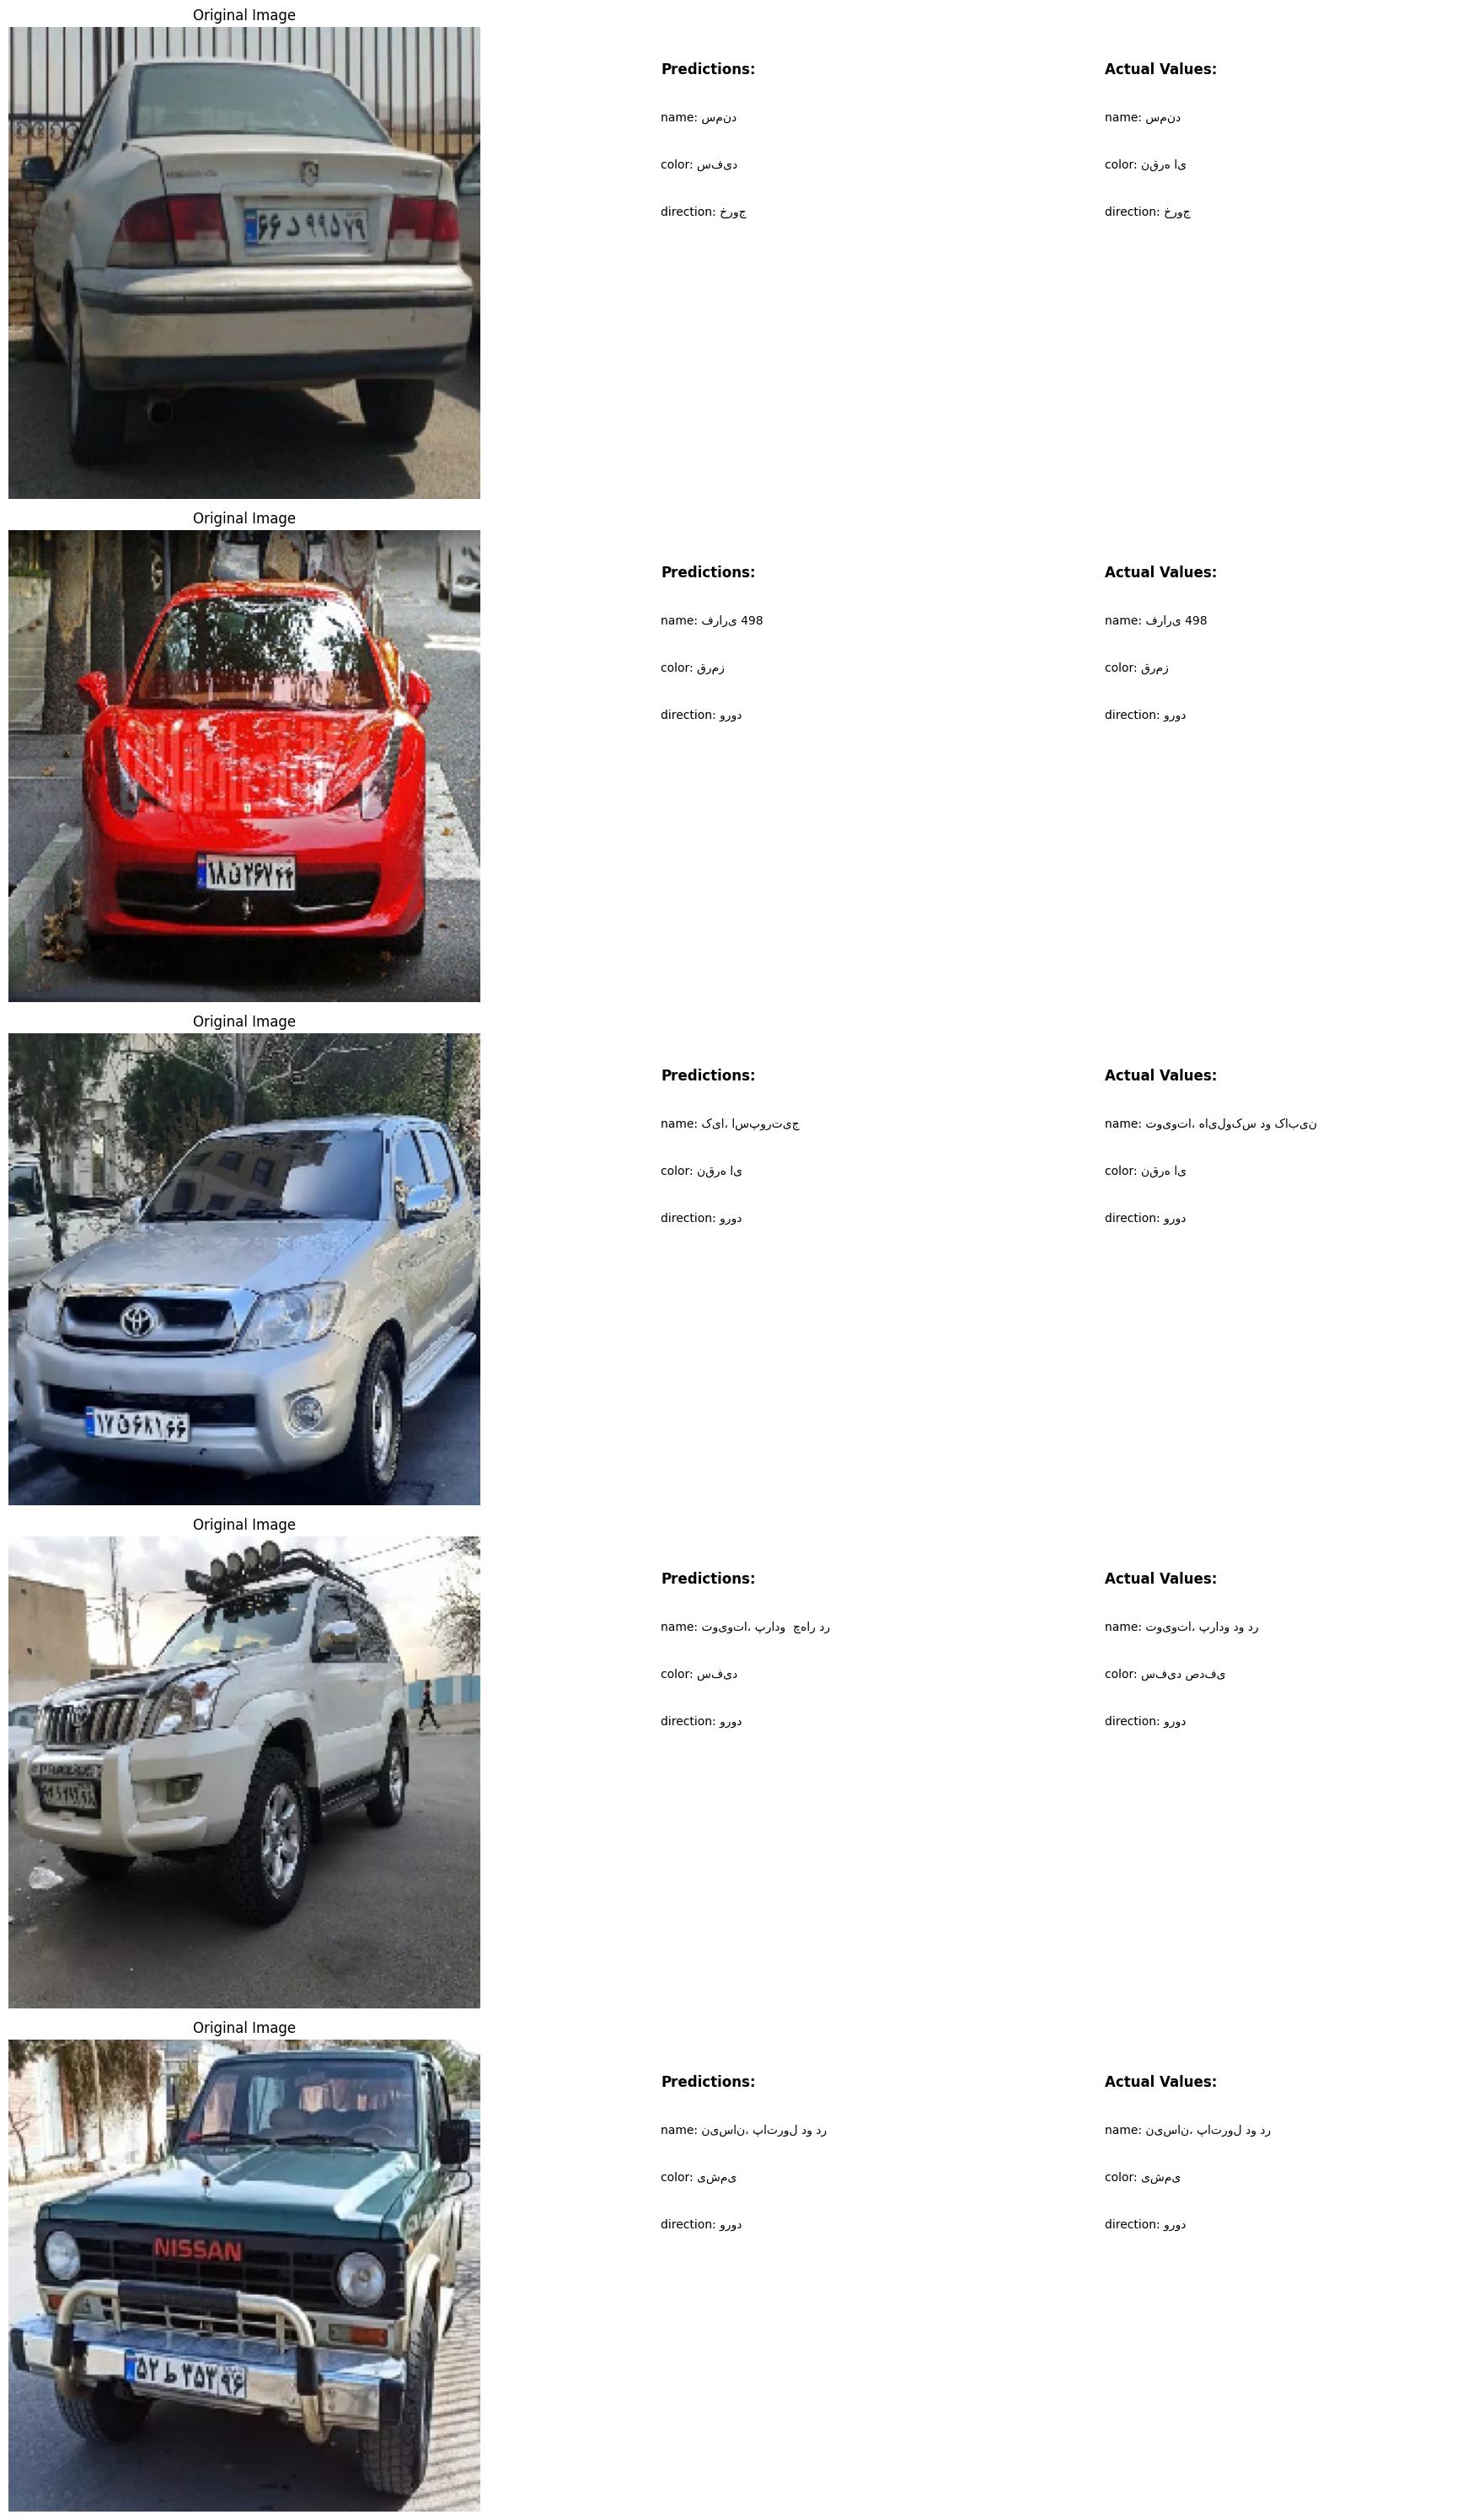

In [24]:
def predict_and_display_random_images(metadata, model, num_images=5):
    random_images = metadata.sample(n=num_images)

    plt.figure(figsize=(20, 6*num_images))

    for i, (_, row) in enumerate(random_images.iterrows()):
        img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=img_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        predictions = model.predict(img_array)

        results = {}
        for column, pred in zip(categorical_columns, predictions.values()):
            predicted_class = label_encoders[column].inverse_transform([np.argmax(pred[0])])[0]
            results[column] = predicted_class

        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original Image")

        plt.subplot(num_images, 2, 2*i+2)
        plt.axis('off')
        plt.text(0.1, 0.9, "Predictions:", fontsize=12, fontweight='bold')
        for j, (key, value) in enumerate(results.items()):
            plt.text(0.1, 0.8 - j*0.1, f"{key}: {value}", fontsize=10)

        plt.text(0.6, 0.9, "Actual Values:", fontsize=12, fontweight='bold')
        for j, column in enumerate(categorical_columns):
            plt.text(0.6, 0.8 - j*0.1, f"{column}: {row[column]}", fontsize=10)

    plt.tight_layout()
    plt.show()

predict_and_display_random_images(val_data, model)